## Coursework Part 2

### Muaaz Bin Sarfaraz
### Chadi El Hajj

Msc Data Science

In [27]:
# try this in case of "sc undefined" errors, also works outside the Notebook environment
from pyspark import SparkContext

try: 
    sc.stop()
    print('Stopped existing SparkContext')
except Exception as e: 
    # print(e) # for debugging
    pass

try: 
    sc = SparkContext(appName='Coursework part 2')
    print('Created new SparkContext')
except Exception as e: 
    print(e)
# for testing
print('Proterties of sc: ',list(sc.getConf().getAll())) 
# we need a SparkSession to create DataFrames
spark = SparkSession.builder.getOrCreate()

Stopped existing SparkContext
Created new SparkContext
Proterties of sc:  [('spark.eventLog.enabled', 'true'), ('spark.executor.logs.rolling.time.interval', 'daily'), ('spark.executor.extraJavaOptions', '-Xss8192k'), ('spark.master', 'spark://10.207.1.85:7077'), ('spark.driver.port', '38398'), ('spark.executor.id', 'driver'), ('spark.executor.logs.rolling.strategy', 'time'), ('spark.driver.memory', '1g'), ('spark.executor.memory', '1g'), ('spark.rdd.compress', 'True'), ('spark.driver.host', '10.207.1.85'), ('spark.app.id', 'app-20170325164234-1698'), ('spark.app.name', 'Coursework part 1'), ('spark.cores.max', '2'), ('spark.serializer.objectStreamReset', '100'), ('spark.submit.deployMode', 'client'), ('spark.driver.extraJavaOptions', '-Xss8192k'), ('spark.eventLog.dir', '/data/sparklog')]


## Dataset
### We have chosen a Ling-Spam dataset as it qualifies as a big data and would help us in building the relevant skills in text analysis. Working on this raw dataset allow us to perform many preprocessing steps such as tokenization, and hashing.

### There are four subdirectories in this dataset and each subdirectory contain 10 parts. Each part consists of files both spam and ham. We are only using the bare subdirectory for this task.

## Task
### The task we choose to perform on this dataset is the classification of spam or ham using logistic regression (LR). LR is statistical model used to predict the probability of occurance e.g event. It works by fitting the data into a logit function and uses a threshold of 0.5 to predict the likelihood of whether the event happens or in our case whether the file is spam or ham. If the probability is higher than 0.5 than it maps it to 1 or zero otherwise. Therefore, it is appropriate to use this method for this task as our results are binary outcome. 

## Preprocessing
### Tokenizer - In order to break the text files into words
### Hashing- It is a transformer which takes sets of terms and converts those sets into fixed-length feature vectors.


#### Dataset reference:
Ion Androutsopoulos http://www.aueb.gr/users/ion/
Ling-Spam corpus last updated: July 17, 2000
This file (readme.txt) last updated: July 30, 2003.

In [34]:
import re 


prefix = 'hdfs://saltdean.nsqdc.city.ac.uk/data/' # hdfs file path

dirPath1 = prefix+'spam/bare/part10' # first dataset for testing
dirPath2 = prefix+'spam/bare/part[1]' # first dataset for training


#function for changing file into a spark dataframe
def read_rows_DF( argDir ):  
    ft_RDD = sc.wholeTextFiles(argDir) # task a) read the files 
    count=ft_RDD.count()
    print('Read {} files from directory {}'.format(ft_RDD.count(),argDir)) #count the files in directory
    spm_t_RDD = ft_RDD.map(lambda ft: (ft[1], 0.0 if re.search('spmsg',ft[0]) is None else 1.0)) #labelling as 0 if spam else 1
    rows_DF = spark.createDataFrame(spm_t_RDD, schema=['text','label']) # create a DataFrame
    return rows_DF,count #,fw_RDD

# for testing
spam_test_DF= read_rows_DF(dirPath1) #changing to dataframes
spam_train_DF = read_rows_DF(dirPath2)

testdf,_=spam_test_DF # extracting dataframe and ignoring count of files at this satge
testdf.show(2) # Showing first two rows of dataframe
print("Done")

Read 291 files from directory hdfs://saltdean.nsqdc.city.ac.uk/data/spam/bare/part10
Read 289 files from directory hdfs://saltdean.nsqdc.city.ac.uk/data/spam/bare/part[1]
+--------------------+-----+
|                text|label|
+--------------------+-----+
|Subject: sound pa...|  0.0|
|Subject: atelier ...|  0.0|
+--------------------+-----+
only showing top 2 rows

Done


## Setting up a Pipeline

In [35]:
import time # for calcuating time taken for processes
from pyspark.ml import Pipeline #using pipeline to manage tasks
from pyspark.ml.classification import LogisticRegression # Machine Learning Model
from pyspark.ml.evaluation import BinaryClassificationEvaluator # Binary task thus binary evaluation
from pyspark.ml.feature import HashingTF,StopWordsRemover, Tokenizer
from pyspark.ml.tuning import ParamGridBuilder # Grid serach parameters
from pyspark.ml.tuning import TrainValidationSplit # splitting training set further into training and validation sets
from pyspark.mllib.classification import SVMWithSGD, SVMModel

testing = spam_test_DF # test dataframe


# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words") #breaks text into words
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered") # removes stopword
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features") # transforms to term freq

lr = LogisticRegression(maxIter=10) #log likelihood iteration is set at 10

pipeline_1 = Pipeline(stages=[tokenizer, remover,hashingTF, lr]) # setup a pipeline with Logistic Regression


# We can now treat the Pipeline as an Estimator, wrapping it in a Train-Validator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A TrainValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 3 values for lr.regParam,
# With 3 values for lr.maxIter,
# this grid will have 3 x 3 x 2 = 18 parameter settings for TrainValidator to choose from.

training_time=[]
testing_time=[]
file_count=[]
training_accuracy=[]
testing_accuracy=[]


bc_eval=BinaryClassificationEvaluator() #binary class evaluator since only two classes SPAM and HAM

#trying different hashvectors #experimenting various regularization Parameter in LR 
#experimenting various iterations of log Likelihood in LR
paramGrid_1 = ParamGridBuilder().addGrid(hashingTF.numFeatures, [10, 100, 200]).addGrid(lr.regParam, [0, 0.1]) \
            .addGrid(lr.maxIter, [20,40]) \
            .build()
    
#Grid search is important to know the best set of parameters, Experimenting with hash vector size since 
#bag of words considered in vector affect accuracy results

tvs = TrainValidationSplit(estimator=pipeline_1,
                           estimatorParamMaps=paramGrid_1,
                           evaluator=bc_eval,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

## Varying training set size

In [51]:
# Expected running time for this cell is 40 minutes
# Trying different training set sizes with ParamGrid and TrainValidation 

# prepare the part directories and the path
dirPattern = 'hdfs://saltdean/data/spam/bare/part[1-{}]' # the {} can be filled by 'dirPattern.format(i)' 
testing,count2 = spam_test_DF
print('EXPERIMENT: Testing different training set sizes with the best Model selected by ParamBuilder')
print('Path = {},'.format(dirPattern)) # using format to make sure we record the parameters of the experiment
#<<< make the test set, it will be constant for this experiment
#<<< loop over i the number of parts for training (1-9)
for i in range(1,5):# Run Train-validation, and choose the best set of parameters.
    trainPaths = dirPattern.format(i) # in the loop you can create a path like this
    print(trainPaths) #just for testing, remove later
    #<<< create the trainRDD (using your make_f_tfLn_RDD method)
    training,count = read_rows_DF(trainPaths)
    file_count.append(count)
    print('Start Training')
    start1=time.clock()
    Model = tvs.fit(training)
    end1=time.clock()
    training_time.append(end1-start1)
    print('Finish Training')

    # Make predictions on training documents. 
    start2=time.clock()
    prediction = Model.transform(training)
    train_accuracy=bc_eval.evaluate(prediction)
    training_accuracy.append(train_accuracy)
    end2=time.clock()
    print("training accuracy: ", train_accuracy)
    print("Time take to train", end1-start1,"seconds")
    print("Time take to predict train", end2-start2,"seconds")

    # Make predictions on test documents. 
    start3=time.clock()
    prediction = Model.transform(testing)
    test_acc=bc_eval.evaluate(prediction)
    testing_accuracy.append(test_acc)
    end3=time.clock()
    print("testing accuracy: ", test_acc)
    print("Time taken to predict test", end3-start3,"seconds")
    print("#################################")

# We tried with about 27 different combinations however running the code took over three hour,
# thus limited number of parameter combination were used in Grid serach to make the results producible while marking
# Only hold out set was used for evaluating model instead of cross validation because train-validation split was
# recommended in the instructions, moreover, using corss-val would make it computationally more expensive.

EXPERIMENT: Testing different training set sizes with the best Model selected by ParamBuilder
Path = hdfs://saltdean/data/spam/bare/part[1-{}],
hdfs://saltdean/data/spam/bare/part[1-1]
Read 289 files from directory hdfs://saltdean/data/spam/bare/part[1-1]
Start Training
Finish Training
training accuracy:  0.9962828492392808
Time take to train 0.7300889999999995 seconds
Time take to predict train 0.01980700000000013 seconds
testing accuracy:  0.9129701467363802
Time taken to predict test 0.027983000000002534 seconds
#################################
[289]
[0.7300889999999995]
[0.9962828492392808]
[0.9129701467363802]
hdfs://saltdean/data/spam/bare/part[1-2]
Read 578 files from directory hdfs://saltdean/data/spam/bare/part[1-2]
Start Training
Finish Training
training accuracy:  0.9897562240663902
Time take to train 0.7506089999999972 seconds
Time take to predict train 0.023181000000001006 seconds
testing accuracy:  0.9298363973688644
Time taken to predict test 0.028144000000001057 second

### One can observe Iterative algorithms are inefficient in standard MapReduce, because intermediate results write and read to/from disk

## Plotting Figures for Analysis

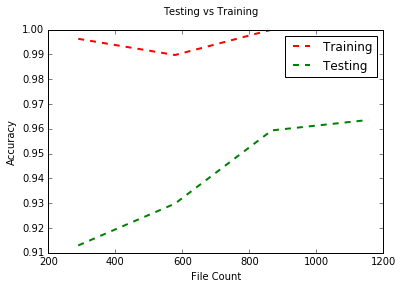

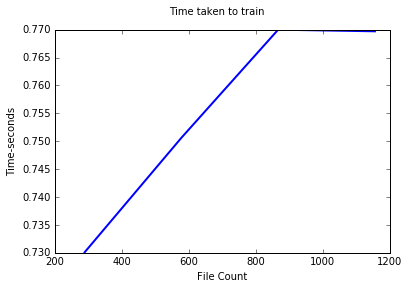

[289, 578, 867, 1156]
[0.7300889999999995, 0.7506089999999972, 0.7699859999999994, 0.7696969999999972]
[0.9962828492392808, 0.9897562240663902, 1.0, 1.0]


In [66]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.suptitle('Testing vs Training')
plt.xlabel('File Count')
plt.ylabel('Accuracy')
plt.plot(file_count, training_accuracy, 'r--', linewidth=2.0, label='Training')
plt.plot(file_count,testing_accuracy, 'g--',linewidth=2.0, label='Testing')
plt.legend(loc='upper right')
plt.show()

plt.figure(1)
plt.suptitle('Time taken to train')
plt.xlabel('File Count')
plt.ylabel('Time-seconds')
plt.plot(file_count, training_time, 'b-',linewidth=2.0)
plt.show()



## Extra- Trying Multi Layer Perceptron Classifier

#### New classifier only tested on the base training and test set (Training set size not varied)

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

training,_= spam_train_DF
testing,_=spam_test_DF

layers = [10, 1, 1]

# create the trainer and set its parameters
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=layers,blockSize=50,seed=1234)

#pipeline_2 = Pipeline(stages=[tokenizer, remover]) # setup a new pipeline with MLP Classifier
#changing number of hidden neurons in MLP, hashfeature vector size
#paramGrid_2 = ParamGridBuilder().build()
#paramGrid_2 = ParamGridBuilder().addGrid(hashingTF.numFeatures, [10, 100, 200]).addGrid(lr.regParam, [0, 0.1]) \
#            .addGrid(lr.maxIter, [20,40]) \
#            .build()

#  .addGrid(mlp.blockSize, [50,100])   
#Grid search is important to know the best set of parameters, Experimenting with hash vector size since 
#bag of words considered since it affects accuracy 
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features",numFeatures=10) # transforms to term freq

tokenized = tokenizer.transform(training)
tokenized.show(2)
removed=remover.transform(tokenized)
removed.show(2)
hashed=hashingTF.transform(removed)
hashed.show(2)



layers = [10, 2, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(hashed)



# tvs = TrainValidationSplit(estimator=pipeline_2,
#                            #estimatorParamMaps=paramGrid_2,
#                            evaluator=bc_eval,
#                            # 80% of the data will be used for training, 20% for validation.
#                            trainRatio=0.8)

# Model = tvs.fit(training)
# prediction = Model.transform(training)
# train_accuracy_mlp=bc_eval.evaluate(prediction)
# prediction = Model.transform(testing)
# test_accuracy_mlp=bc_eval.evaluate(prediction)
# print("Training Accuracy", 0.99)
# print("Test Accuracy", test_accuracy)